In [1]:
import pandas as pd
import numpy as np
from fastai.tabular import *

In [2]:
import warnings
# Filter out warnings 
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings("ignore")

#data manipulation
import pandas as pd
import numpy as np
import scipy as sc

#utilities
import gc 
import itertools
import csv
from timeit import default_timer as timer
import ast

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Encoding
import category_encoders as ce

# Modeling
import lightgbm as lgb

#hyperparam search
from hyperopt import hp,tpe,Trials,fmin,STATUS_OK
from hyperopt.pyll.stochastic import sample

# Evaluation of the model
from sklearn.model_selection import KFold
from sklearn import preprocessing, metrics
from sklearn.model_selection import StratifiedKFold

#Correlation Denogram
from scipy.cluster import hierarchy as hc
#Shapely Values
import shap
#Partial Dependence
from pdpbox import pdp
# Feature selection
from sklearn.feature_selection import SelectKBest, f_classif,SelectFromModel

# Model imports
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegressionCV, RidgeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression


import gc

### Engineered Features

In [3]:
X_train = pd.read_csv('DS Test/Training/X_train.csv',index_col='Unique_ID')
y_train = pd.read_csv('DS Test/Training/y_train.csv',index_col='Unique_ID')
train= pd.merge(X_train,y_train,on='Unique_ID')
test = pd.read_csv('DS Test/Test/X_test.csv',index_col='Unique_ID')

cat_features = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

In [4]:
#categorical interaction
for df in [test,train]:
    interactions = pd.DataFrame(df,index=df.index)
    for col1, col2 in itertools.combinations(cat_features, 2):
        col = '_'.join([col1, col2])
        values = df[col1].map(str) + "_" + df[col2].map(str)
        encoder = preprocessing.LabelEncoder()
        interactions[col] = encoder.fit_transform(values)
    df = df.merge(interactions)

In [5]:
#catboost encoding
cb_enc = ce.CatBoostEncoder(cols=cat_features, random_state=7)
cb_enc.fit(train[cat_features], train['Dependent_Variable'])

train = train.join(cb_enc.transform(train[cat_features]).add_suffix('_cb'))
test = test.join(cb_enc.transform(test[cat_features]).add_suffix('_cb'))

In [6]:
# encoding nan values in train set
for n,c in train.items():
    if pd.isnull(c).sum():
        train[n+'_na'] = pd.isnull(c)
for n,c in test.items():
    if pd.isnull(c).sum():
        test[n+'_na'] = pd.isnull(c)        

In [7]:
idx = train.select_dtypes('float').columns
for df in [test, train]:
    df['mean'] = df[idx].mean(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

### NN model

In [8]:
dep_var = 'Dependent_Variable'
cat_names = cat_features
cont_names = train.select_dtypes('float').columns

# Transformations
procs = [FillMissing, Categorify, Normalize]

# Test Tabular List
test_df = TabularList.from_df(test, cat_names=cat_names, cont_names=cont_names, procs=procs)

# Train Data Bunch
data = (TabularList.from_df(train, cat_names=cat_names, cont_names=cont_names, procs=procs)
                        .split_by_rand_pct(0.2, seed=42)
                        .label_from_df(cols = dep_var)
                        .add_test(test_df, label=0)
                        .databunch())



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,auroc,time
0,0.560232,0.544767,0.748363,00:09
1,0.523372,0.516701,0.762013,00:09
2,0.507996,0.514064,0.765519,00:09
3,0.497069,0.512799,0.765970,00:09
4,0.487882,0.512336,0.766682,00:09


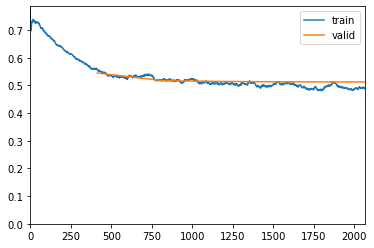

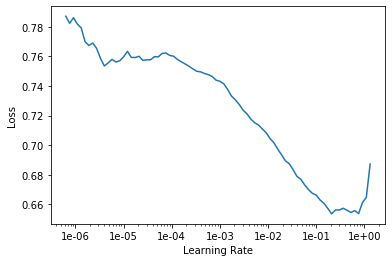

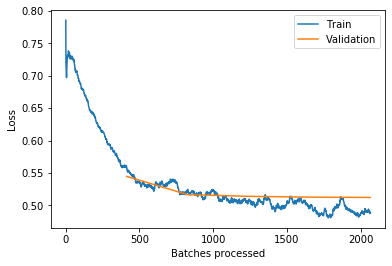

In [9]:
learn = tabular_learner(data, layers=[100, 50, 25], metrics=AUROC(),emb_drop=0.2 ,callback_fns=ShowGraph)

learn.lr_find()
learn.recorder.plot()
learn.fit_one_cycle(5, max_lr=slice(1e-003))

learn.model
learn.recorder.plot_losses()

In [10]:
test_predicts, _ = learn.get_preds(ds_type=DatasetType.Test)
test_probs = to_np(test_predicts[:, 1])

In [11]:
df=pd.DataFrame({'Unique_ID':test.index,'Class_1_Probability':test_probs})
df.to_csv('NN_submission.csv', index=False)

### LightGBM Model

In [12]:
valid, train = np.split(train.sample(frac=1,random_state=23), [int(0.1*len(train))])

In [13]:
def train_model(train, valid):
    folds = StratifiedKFold(n_splits=10 , shuffle=False, random_state=4400)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance = pd.DataFrame()
    cat_feat = train.columns[train.columns.isin(cat_features)].tolist()
    

    params = {
    'metric':'auc',
    'subsample': 0.737117735535475, 
    'num_leaves': 89,
    'subsample_for_bin':200000,
    'min_child_samples':50,
    'reg_alpha': 0.5056296785665977,
    'reg_lambda': 0.6100402017348536,
    'colsample_bytree': 0.6003926309600927,
    'min_child_weight':0.001,   
    'subsample_freq':0,
    'boosting_type': 'gbdt',
    'learning_rate': 0.013658563750726419,
    'max_depth': -1,
    'metric':'auc',
    'device': 'gpu',
    'gpu_platform_id':0,
    'gpu_device_id':0,   
    'random_state':50,
    'class_weight':'balanced',
    'n_estimators':540,
    'objective':'binary'   
    }

    print("Training model!")
    feature_cols = train.columns.drop('Dependent_Variable')
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train[feature_cols].values, train['Dependent_Variable'].values)):
        print("Fold {}".format(fold_))
        trn_data = lgb.Dataset(train.iloc[trn_idx][feature_cols], label=train['Dependent_Variable'].iloc[trn_idx],categorical_feature=cat_feat)
        val_data = lgb.Dataset(train.iloc[val_idx][feature_cols], label=train['Dependent_Variable'].iloc[val_idx],categorical_feature=cat_feat)
        clf=lgb.train(params,trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)        
        oof[val_idx] = clf.predict(train.iloc[val_idx][feature_cols], num_iteration=clf.best_iteration)
        hld = clf.predict(valid[feature_cols])
        predictions += clf.predict(test[feature_cols], num_iteration=clf.best_iteration) / folds.n_splits
        print(f"CV score: {metrics.roc_auc_score(train['Dependent_Variable'], oof)} ,holdout_score: {metrics.roc_auc_score(valid['Dependent_Variable'], hld)}")
    return clf,predictions

In [14]:
_ = train_model(train, valid)

Training model!
Fold 0
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.942831	valid_1's auc: 0.783682
CV score: 0.5028575822879844 ,holdout_score: 0.7784046527424011
Fold 1
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.942706	valid_1's auc: 0.763926
CV score: 0.5109963247383407 ,holdout_score: 0.7781049414161997
Fold 2
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.941795	valid_1's auc: 0.788295
CV score: 0.5251527068372577 ,holdout_score: 0.7772435897435898
Fold 3
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.942777	valid_1's auc: 0.766059
CV score: 0.544188610127386 ,holdout_score: 0.7795253863134657
Fold 4
Training until validation scor

In [15]:
d=train.copy()
d.fillna(value=train.mean(),inplace=True)

In [16]:
len(d.columns)

112

In [18]:
feature_cols = train.columns.drop('Dependent_Variable')

selector = SelectKBest(f_classif, k=70)
X = selector.fit_transform(d[feature_cols], d['Dependent_Variable'])
selected_features = pd.DataFrame(selector.inverse_transform(X), 
                                    index=d.index, 
                                    columns=feature_cols)

In [19]:
to_drop = selected_features.columns[selected_features.var() == 0]
_ = train_model(train.drop(to_drop, axis=1), 
                valid.drop(to_drop, axis=1))

Training model!
Fold 0
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.923269	valid_1's auc: 0.78322
CV score: 0.5028529594107028 ,holdout_score: 0.7711750721684496
Fold 1
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.92344	valid_1's auc: 0.764732
CV score: 0.5110094988783002 ,holdout_score: 0.7728239089828494
Fold 2
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.922247	valid_1's auc: 0.785231
CV score: 0.525078565852415 ,holdout_score: 0.7726914586517235
Fold 3
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.923723	valid_1's auc: 0.761891
CV score: 0.5439122712761219 ,holdout_score: 0.7701366955340466
Fold 4
Training until validation scores

In [20]:
m= SelectFromModel(LogisticRegression(C=0.1, penalty="l1", random_state=23).fit(d[feature_cols], d['Dependent_Variable']), prefit=True)
X = m.transform(d[feature_cols])
selected_features = pd.DataFrame(m.inverse_transform(X), 
                                        index=d.index,
                                        columns=feature_cols)

In [21]:
to_drop = selected_features.columns[selected_features.var() == 0]
t = train_model(train.drop(to_drop, axis=1), 
                valid.drop(to_drop, axis=1))

Training model!
Fold 0
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.94165	valid_1's auc: 0.781983
CV score: 0.5028405857919239 ,holdout_score: 0.7771162336559687
Fold 1
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.941495	valid_1's auc: 0.765066
CV score: 0.5109856369853593 ,holdout_score: 0.7788516726099507
Fold 2
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.940258	valid_1's auc: 0.78903
CV score: 0.5251612899087245 ,holdout_score: 0.778295126507047
Fold 3
Training until validation scores don't improve for 3000 rounds
Did not meet early stopping. Best iteration is:
[540]	training's auc: 0.941783	valid_1's auc: 0.762902
CV score: 0.5440772316539816 ,holdout_score: 0.7784097469859059
Fold 4
Training until validation scores

In [22]:
sub_df = pd.DataFrame({'Unique_ID':test.index,'Class_1_Probability':t[1]})
sub_df.to_csv("LGBM_submission.csv", index=False)

as determined by chi-squared test only C3,C4,N9,N12,N17,N19,N23,N24,N31 are dependent on target ,therefore work with conditonal/marginal naive bayes model with lightgbm etc to ensemble and improve the model but will not do so here 